# Plotting the optical components spectral response

Created on Tue Nov 22 16h24m,  2022

This is a script for the development of general tests

@author: denis


In [ ]:
# PLOT SKY SED
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from AIS.Spectral_Energy_Distribution import Sky

ss = pd.read_csv("../AIS/Spectral_Energy_Distribution/moon_magnitude.csv")
wv = np.linspace(350, 1100, 100)
colors = ["r", "b", "g", "k"]
for idx, moon in enumerate(["new", "first quarter", "third quarter", "full"]):
    sky = Sky()
    sky_sed = sky.calculate_sed(moon, wv)
    plt.semilogy(wv, sky_sed[0], colors[idx], alpha=0.8, label=moon)
    plt.semilogy(
        ss["wavelength"], sky._calculate_photons_density(ss[moon]), "o" + colors[idx]
    )

plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("SED (photons/m2/m)")
plt.show()

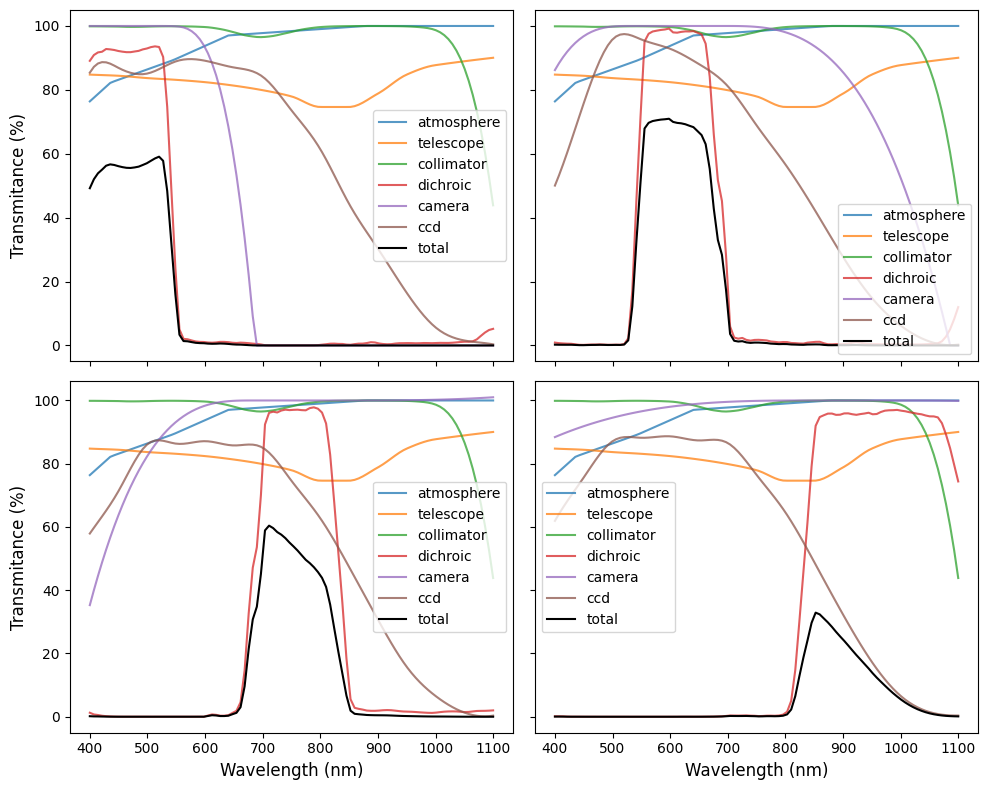

In [ ]:
# PLOT THE SPECTRAL RESPONSE OF EACH COMPONENT OF ONE CHANNEL
import os

import matplotlib.pyplot as plt
import numpy as np

from AIS.Spectral_Response import Atmosphere, Channel, Telescope

wv = np.linspace(400, 1100, 100)

fig, axes = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10,8))
axes = axes.flatten()
for ch, ax in enumerate(axes):
    ch +=1
    sr_total = np.ones(100) * 100
    colors_list = [
    "#1f77b4",  # azul
    "#ff7f0e",  # laranja
    "#2ca02c",  # verde
    "#d62728",  # vermelho
    "#9467bd",  # roxo
    "#8c564b",  # marrom
    "#e377c2",  # rosa
    "#7f7f7f",  # cinza
    "#bcbd22",  # verde oliva
    "#17becf"   # azul claro
]
    atm = Atmosphere()
    sr = atm.get_spectral_response(wv, 1, "photometric")
    sr_total *= sr
    ax.plot(wv, sr * 100, '-', label="atmosphere",  color=colors_list[0], alpha=0.75)
    tel = Telescope()
    sr = tel.get_spectral_response(wv)
    sr_total *= sr
    ax.plot(wv, sr * 100, '-', label="telescope",  color=colors_list[1], alpha=0.75)

    channel = Channel(ch)

    for idx, component in enumerate(['collimator', 'dichroic', 'camera', 'ccd']):
        if idx < 1:
            comp_string = component
        else:
            comp_string = f"Channel {ch}/{component}"        
        sr = channel.get_spectral_response(wv, comp_string+ ".csv")
        sr_total *= sr
        ax.plot(wv, sr * 100, '-', label=component,  color=colors_list[idx+2], alpha=0.75)

    ax.plot(wv, sr_total, 'k', label="total")
    ax.legend()
    if ch == 2:
        ax.legend(loc='lower right')
    if ch in [1, 3]:
        ax.set_ylabel('Transmitance (%)', fontsize = 12)
    if ch in [3, 4]:
        ax.set_xlabel('Wavelength (nm)', fontsize = 12)
    

plt.tight_layout()
plt.savefig(os.path.join("figures", f"Channels.png"), dpi=300, bbox_inches = 'tight')
plt.show()

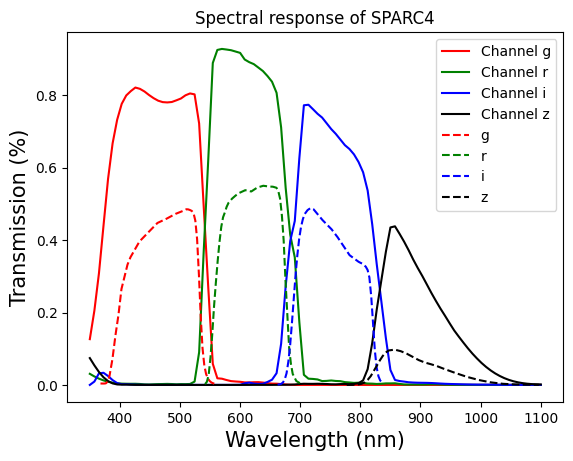

In [63]:
# PLOT SPECTRAL RESPONSE SPARC + SDSS WITH TELESCOPE

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from AIS.Artificial_Image_Simulator import Artificial_Image_Simulator

# http://www.ioa.s.u-tokyo.ac.jp/~doi/sdss/SDSSresponse.html

font = 15
sed = np.ones(100)
wv = np.linspace(350, 1100, 100)
colors = ["r", "g", "b", "k"]
ccd_operation_mode = {
    "em_mode": "Conv",
    "em_gain": 1,
    "preamp": 1,
    "readout": 1,
    "binn": 1,
    "t_exp": 1,
    "image_size": 100,
}
dict_channel_responses = {"Wavelength (nm)": wv}
for i in [1, 2, 3, 4]:
    ais = Artificial_Image_Simulator(
        ccd_operation_mode, channel_id=i, ccd_temperature=-70
    )
    ais.write_source_sed(wv, sed)
    ais.create_sky_sed(moon_phase="new")
    # ais.apply_atmosphere_spectral_response(sky_condition="regular")
    # ais.apply_telescope_spectral_response()
    ais.apply_sparc4_spectral_response(acquisition_mode="photometry")
    channel_response = ais.source_sed
    string_label = f"Channel {['g', 'r', 'i', 'z'][i-1]}"
    plt.plot(
        wv,
        channel_response,
        colors[i - 1],
        label=string_label,
    )
    dict_channel_responses[string_label + " (%)"] = channel_response

base_path = os.path.join("data_files", "SDSS_tel")
file = os.path.join(base_path, "g_filter.csv")
data = pd.read_csv(file)
plt.plot(data["Wavelength (angstroms)"] / 10, data["Transmission"], "r--", label="g")
file = os.path.join(base_path, "r_filter.csv")
data = pd.read_csv(file)
plt.plot(data["Wavelength (angstroms)"] / 10, data["Transmission"], "g--", label="r")
file = os.path.join(base_path, "i_filter.csv")
data = pd.read_csv(file)
plt.plot(data["Wavelength (angstroms)"] / 10, data["Transmission"], "b--", label="i")
file = os.path.join(base_path, "z_filter.csv")
data = pd.read_csv(file)
plt.plot(data["Wavelength (angstroms)"] / 10, data["Transmission"], "k--", label="z")
df = pd.DataFrame.from_dict(dict_channel_responses)
csv_file = os.path.join("data_files", "sparc4_spectral_response.csv")
df.to_csv(csv_file, index=False)

plt.legend()
plt.xlabel("Wavelength (nm)", fontsize=font)
plt.ylabel("Transmission (%)", fontsize=font)
plt.title("Spectral response of SPARC4")
plt.savefig(os.path.join("figures", "sparc4_spectral_response.png"), dpi=300)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

csv_file = os.path.join("data_files", "sparc4_spectral_response.csv")

df = pd.read_csv(csv_file)
plt.plot(df["Wavelength (nm)"], df["Channel z (%)"])
plt.show()

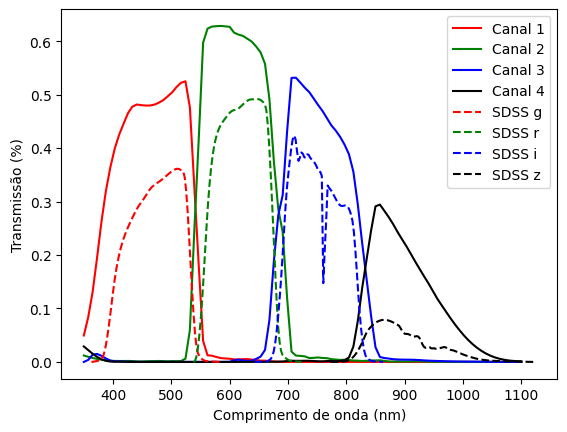

In [61]:
# PLOT SPECTRAL RESPONSE SPARC + SDSS WITH TELESCOPE AND ATM

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from AIS.Artificial_Image_Simulator import Artificial_Image_Simulator

# http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=SLOAN/SDSS.g&&mode=browse&gname=SLOAN&gname2=SDSS#filter

sed = np.ones(100)
wv = np.linspace(350, 1100, 100)
colors = ["r", "g", "b", "k"]

ccd_operation_mode = {
    "em_mode": "Conv",
    "em_gain": 1,
    "preamp": 1,
    "readout": 1,
    "binn": 1,
    "t_exp": 1,
    "image_size": 100,
}
for i in [1, 2, 3, 4]:
    ais = Artificial_Image_Simulator(
        ccd_operation_mode, channel_id=i, ccd_temperature=-70
    )
    ais.write_source_sed(wv, sed)
    ais.create_sky_sed(moon_phase="new")
    ais.apply_atmosphere_spectral_response(sky_condition="regular")
    ais.apply_telescope_spectral_response()
    ais.apply_sparc4_spectral_response(acquisition_mode="photometry")
    plt.plot(wv, ais.source_sed, colors[i - 1], label=f"Canal {i}")

base_path = os.path.join("data_files", "SDSS_atm_tel")
for idx, filter in enumerate(["g", "r", "i", "z"]):
    file = os.path.join(base_path, f"SLOAN_SDSS.{filter}.dat")
    wv, resp = [], []
    with open(file) as arq:
        lines = arq.read().splitlines()
    for line in lines:
        tmp1, tmp2 = line.split(" ")
        wv.append(float(tmp1) / 10)
        resp.append(float(tmp2))
    plt.plot(wv, resp, f"{colors[idx]}--", label=f"SDSS {filter}")

plt.legend()
plt.xlabel("Comprimento de onda (nm)")
plt.ylabel("Transmissão (%)")
# plt.title("Spectral response of the atm + telescope + sparc4")
plt.savefig(os.path.join("figures", "sparc4_photometry.png"), dpi=300)
plt.show()

In [ ]:
# PLOT ATM SPECTRAL RESPONSE


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from AIS.Spectral_Response import Atmosphere

obj_wavelength = np.linspace(350, 1100, 100)
ss = pd.read_csv("../AIS/Spectral_Response/atmosphere/willton.csv")
wv = ss["Wavelength (nm)"]
C = -0.43428

photometric = 10 ** (C * ss["photometric"])
good = 10 ** (C * ss["good"])
regular = 10 ** (C * ss["regular"])
plt.plot(wv, photometric * 100, "bo", label="photometric")
plt.plot(wv, good * 100, "ro", label="good")
plt.plot(wv, regular * 100, "ko", label="regular")

atmosphere = Atmosphere()
spectral_response = atmosphere.get_spectral_response(obj_wavelength, 1)
plt.plot(obj_wavelength, spectral_response * 100, "b")
spectral_response = atmosphere.get_spectral_response(obj_wavelength, 1, "good")
plt.plot(obj_wavelength, spectral_response * 100, "r")
spectral_response = atmosphere.get_spectral_response(obj_wavelength, 1, "regular")
plt.plot(obj_wavelength, spectral_response * 100, "k")
plt.xlabel("Wavelength (nm)", fontsize=14)
plt.ylabel("Transmitance (%)", fontsize=14)
plt.legend(loc="lower right")
plt.savefig("figures/atmosphere_spec_response.png", dpi=300, bbox_inches="tight")

In [ ]:
# PLOT ATM SPECTRAL RESPONSE


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from AIS.Spectral_Response import Atmosphere

obj_wavelength = np.linspace(350, 1100, 10)
atmosphere = Atmosphere()
spectral_response_1 = atmosphere.get_spectral_response(obj_wavelength, 1, "photometric")
plt.plot(obj_wavelength, spectral_response_1, "b", label="airmass=1")
atmosphere = Atmosphere()
spectral_response_2 = atmosphere.get_spectral_response(obj_wavelength, 2, "photometric")
plt.plot(obj_wavelength, spectral_response_2, "r", label="airmass=2")
# print(spectral_response_1 / spectral_response_2)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmitance")
plt.legend()
# plt.savefig("figures/atmosphere_spec_response.png", dpi=300)

In [ ]:
# PLOT SPECTRAL RESPONSE TELESCOPE

import os
from sys import exit

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import splev, splrep
from scipy.optimize import curve_fit

from AIS.Spectral_Response import Telescope

date = "20230328"
fontsize = 14
base_path = os.path.join("..", "AIS", "Spectral_Response", "telescope")
obj_wavelength = np.linspace(350, 1100, 100)
telescope = Telescope()
spectral_response = telescope.get_spectral_response(obj_wavelength, date) * 100
plt.plot(obj_wavelength, spectral_response, "k-", label="Total response")

# ----------------------------------------------------------------------------------

df = pd.read_csv(os.path.join(base_path, f"reflectance_{date}.csv"))
wv = df["wavelength (nm)"]
M1, M1_std = df["M1 Reflectance"], df["M1 STD"]
M2, M2_std = df["M2 Reflectance"], df["M2 STD"]

ss = pd.read_csv(os.path.join(base_path, "aluminium_curve.csv"))


def func(x, c):
    ss = pd.read_csv(os.path.join(base_path, "aluminium_curve.csv"))
    spl = splrep(ss["Wavelength (nm)"], ss["Transmitance (%)"])
    spectral_response = splev(x, spl)
    return spectral_response * c


popt_M1, _ = curve_fit(func, wv, M1)
popt_M2, _ = curve_fit(func, wv, M2)


plt.plot(
    ss["Wavelength (nm)"],
    ss["Transmitance (%)"] * popt_M1[0],
    "b",
    alpha=0.75,
    label=rf"PM adjustment",
)
plt.plot(
    ss["Wavelength (nm)"],
    ss["Transmitance (%)"] * popt_M2[0],
    "r",
    alpha=0.75,
    label=rf"SM adjustment",
)
plt.errorbar(wv, M1, M1_std, c="tab:orange", label="PM", fmt="o-")
plt.errorbar(wv, M2, M2_std, c="g", label="SM", fmt="o-")
plt.legend(loc="lower right")
plt.xlabel("Wavelength (nm)", fontsize=fontsize)
plt.ylabel("Reflectance (%)", fontsize=fontsize)
plt.savefig(
    os.path.join("figures", "adjust_aluminium_curve.png"), dpi=300, bbox_inches="tight"
)
plt.show()

In [ ]:
# SPECTRAL RESPONSES OF THE POLARIMETRIC COMPONENTS

import os

import matplotlib.pyplot as plt
import numpy as np

from AIS.Spectral_Response import Channel

wv = np.linspace(350, 1100, 100)
channel = Channel(1)
spectral_response = channel.get_spectral_response(wv, "polarizer.csv")
plt.plot(wv, spectral_response, "b", label="Polarizer")

spectral_response = channel.get_spectral_response(wv, "depolarizer.csv")
plt.plot(wv, spectral_response, "r", label="Depolarizer")

spectral_response = channel.get_spectral_response(wv, "retarder.csv")
plt.plot(wv, spectral_response, "g", label="Retarder")

spectral_response = channel.get_spectral_response(wv, "analyzer.csv")
plt.plot(wv, spectral_response, "k", label="Analyser")

plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmitance (%)")
plt.legend()
plt.savefig(os.path.join("figures", "polarimetric_spectral_response.png"), dpi=300)
plt.show()

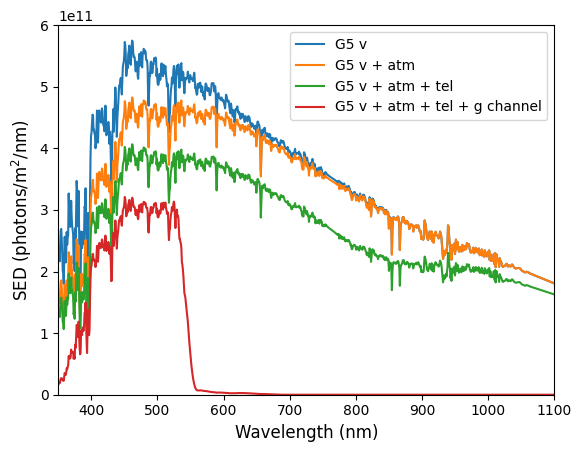

In [4]:
# PLOT SPECTRAL LIBRARY WITH ATM + TELESCOPE + SPARC4
import matplotlib.pyplot as plt

from AIS.Artificial_Image_Simulator import Artificial_Image_Simulator

font = 12
ccd_operation_mode = {
    "em_mode": "Conv",
    "em_gain": 1,
    "preamp": 1,
    "readout": 1,
    "binn": 1,
    "t_exp": 1,
    "image_size": 100,
}

ais = Artificial_Image_Simulator(ccd_operation_mode, 1, -70)

ais.create_source_sed_spectral_library(15, (350, 1100, 1000), spectral_type="g5v")
# ais.create_source_sed_blackbody(15, (350, 1100, 1000), 5700)
ais.create_sky_sed("new")
ais.apply_linear_polarization(50, 0)
plt.plot(ais.wavelength, ais.source_sed[0], label="G5 v")
ais.apply_atmosphere_spectral_response()
plt.plot(ais.wavelength, ais.source_sed[0], label="G5 v + atm")
ais.apply_telescope_spectral_response()
plt.plot(ais.wavelength, ais.source_sed[0], label="G5 v + atm + tel")
ais.apply_sparc4_spectral_response("photometry")
plt.plot(ais.wavelength, ais.source_sed, label="G5 v + atm + tel + g channel")
plt.legend()
plt.xlabel("Wavelength (nm)", fontsize=font)
plt.ylabel(r"SED (photons/m$^2$/nm)", fontsize=font)
plt.xlim(350, 1100)
plt.ylim(0, 6e11)
plt.savefig("figures/spectral_library.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# PLOT SPECTRAL RESPONSE SHIFTS OF THE RETARDER WAVEPLATES

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from AIS.Spectral_Response import Channel

wv = np.linspace(400, 1100, 100)
sed = np.ones(100)
fontsize = 14
ch = Channel(1)
ch.obj_wavelength = wv
trans = ch.get_spectral_response(wv, "retarder.csv") * 100
half = ch._get_spectral_response_custom("retarder_phase_diff_half.csv", "Retardance")
quarter = ch._get_spectral_response_custom(
    "retarder_phase_diff_quarter.csv", "Retardance"
)

csv = os.path.join(
    "..", "AIS", "Spectral_Response", "channel", "retarder_phase_diff_quarter.csv"
)
ss = pd.read_csv(csv)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(7, 8))
fig.subplots_adjust(hspace=0.1)

ax0 = axs[0]
ax0.plot(wv, trans, "k")
ax0.set_ylabel("Transmission (%)", fontsize=fontsize)

ax1 = axs[1]
ax1.plot(wv, half, "b", label="half")
ax1.set_xlabel("Wavelength (nm)", fontsize=fontsize)
ax1.set_ylabel(r"Retardance ($\lambda/2$)", fontsize=fontsize)

ax2 = ax1.twinx()
ax2.plot(wv, quarter, "r", label="quarter")
# ax2.plot(ss["Wavelength (nm)"], ss["Retardance"], "o")
ax2.set_ylabel(r"Retardance ($\lambda/4$)", fontsize=fontsize)
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.savefig(
    os.path.join("figures/lamina_retardadora_transmissao.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [ ]:
# DEPOLARIZER: PHASE SHIFT LINEAR ADJUSTMENT
import os

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

from AIS.Spectral_Response import Channel

base_path = os.path.join("..", "AIS", "Spectral_Response", "channel")
file = "depolarizer_shifts.txt"

dict = {"wavelength": [], "shift": []}
with open(os.path.join(base_path, file), "r") as file:
    text = file.readlines()

for line in text[1:4]:
    line = line.split(",")
    dict["wavelength"].append(float(line[0]))
    dict["shift"].append(float(line[2]))

x, y = np.asarray(dict["wavelength"]), dict["shift"]
slope, intercept, *_ = linregress(x, y)
adjust = lambda x: slope * x + intercept
print(slope, intercept)

fontsize = 14
ch = Channel(1)
wv = np.linspace(350, 1100, 100)
depol = ch.get_spectral_response(wv, "depolarizer.csv") * 100

fig, ax1 = plt.subplots()
ax1.plot(wv, depol, "b-", alpha=0.8, label="transmission")
ax1.set_ylabel("Transmission (%)", fontsize=fontsize)
ax1.set_xlabel("Wavelength (nm)", fontsize=fontsize)

ax2 = ax1.twinx()
ax2.plot(x, y, "ro", alpha=0.75, label="phase shift")
ax2.plot(x, adjust(x), "r-", alpha=0.75, label="linear adjustment")
ax2.set_ylabel("Phase shift (deg)", fontsize=fontsize)
fig.legend(loc="upper left", bbox_to_anchor=(0, 0.3), bbox_transform=ax1.transAxes)

plt.savefig(
    os.path.join("figures", "depolarizador_transmissao.png"),
    dpi=300,
    bbox_inches="tight",
)

In [ ]:
# PLOT SPECTRAL RESPONSE OF AN UNIQUE OPTICAL COMPONENT

import os

import matplotlib.pyplot as plt
import numpy as np

from AIS.Spectral_Response import Channel

fontsize = 14
wv = np.linspace(350, 1100, 100)
ch = Channel(1)
ch.obj_wavelength = wv
trans = ch.get_spectral_response(wv, "ANALYZER.csv") * 100

plt.figure(figsize=(5, 4.5))
plt.plot(wv, trans, "b")
plt.ylabel("Transmission (%)", fontsize=fontsize)
plt.xlabel("Wavelength (nm)", fontsize=fontsize)
plt.savefig(
    os.path.join("figures", "analisador_transmitance.png"), dpi=300, bbox_inches="tight"
)

In [ ]:
# PLOT POLARIZER AND CONTRAST RATIO SPECTRAL RESPONSES

import locale
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from AIS.Spectral_Response import Channel

# locale.setlocale(locale.LC_NUMERIC, "de_DE")

# plt.rcParams["axes.formatter.use_locale"] = True


fontsize = 14

wv = np.linspace(350, 1100, 100)

sed = np.ones(100)


ch = Channel(1)

ch.obj_wavelength = wv

trans = ch.get_spectral_response(wv, "polarizer.csv") * 100

contrast = ch._get_spectral_response_custom(

    "polarizer_contrast_ratio.csv", "Contrast ratio"
)



fig = plt.figure()

ax = fig.add_subplot(111)

ax.plot(wv, trans, "b-", label="Transmission")

ax.set_ylabel("Transmission (%)", fontsize=fontsize)

ax.set_xlabel("Wavelength (nm)", fontsize=fontsize)

ax.tick_params(axis="both", which="major", labelsize=fontsize - 3)


ax2 = ax.twinx()

ax2.semilogy(wv, contrast, "r-", label="Contrast ratio")

ax2.tick_params(axis="both", which="major", labelsize=fontsize - 3)

ax2.set_ylabel(r"Contrast ratio", fontsize=fontsize)

fig.legend(loc="upper right", bbox_to_anchor=(1, 0.8), bbox_transform=ax.transAxes)

plt.savefig(os.path.join("figures", "polarizador.png"), dpi=300, bbox_inches="tight")

plt.show()